In [1]:
!pip install matplotlib
!pip install librosa

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/usr/share/python-wheels/pkg_resources-0.0.0-py2.py3-none-any.whl/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/share/python-wheels/pkg_resources-0.0.0-py2.py3-none-any.whl/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/share/python-wheels/pkg_resources-0.0.0-py2.py3-none-any.whl/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/share/python-wheels/pkg_resources-0.0.0-py2.py3-none-any.whl/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/inf

In [2]:
!pip install pandas scipy==1.3.0


  Using cached scipy-1.3.0.tar.gz (23.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Command errored out with exit status 1:
   command: /home/infasafe/infasafe/.testvenv/bin/python /tmp/tmph4rdu2pi build_wheel /tmp/tmpu1cvvl1w
       cwd: /tmp/pip-install-8anhtnw3/scipy
  Complete output (668 lines):
  lapack_opt_info:
  lapack_mkl_info:
  customize UnixCCompiler
    libraries mkl_rt not found in ['/home/infasafe/infasafe/.testvenv/lib', '/usr/local/lib', '/usr/lib', '/usr/lib/aarch64-linux-gnu']
    NOT AVAILABLE
  
  openblas_lapack_info:
  customize UnixCCompiler
  customize UnixCCompiler
  customize UnixCCompiler
  C compiler: aarch64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC
  
  creating /tmp/tmpt1212k4r/tmp
  creating /tmp/tmpt1212k4r/tmp/tmpt1212k4r
  compile 

In [1]:
import os
import IPython.display as ipd

import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
import pandas as pd  
import librosa as lb 
import librosa.display 

%matplotlib inline

# MFCCs

In [2]:
def extract_mfccs(audio_file_path):
    n_mfcc = 10
    y, sr = librosa.load(audio_file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1) 

# Test Recording

In [3]:
import pyaudio
import wave

In [2]:
audio = pyaudio.PyAudio()

print("----------------------record device list---------------------")
info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

print("-------------------------------------------------------------")


----------------------record device list---------------------
Input Device id  0  -  USB Device 0x46d:0x825: Audio (hw:0,0)
Input Device id  1  -  Microsoft Modern USB Headset: Audio (hw:1,0)
Input Device id  6  -  NVIDIA Jetson Orin NX APE: - (hw:3,0)
Input Device id  7  -  NVIDIA Jetson Orin NX APE: - (hw:3,1)
Input Device id  8  -  NVIDIA Jetson Orin NX APE: - (hw:3,2)
Input Device id  9  -  NVIDIA Jetson Orin NX APE: - (hw:3,3)
Input Device id  10  -  NVIDIA Jetson Orin NX APE: - (hw:3,4)
Input Device id  11  -  NVIDIA Jetson Orin NX APE: - (hw:3,5)
Input Device id  12  -  NVIDIA Jetson Orin NX APE: - (hw:3,6)
Input Device id  13  -  NVIDIA Jetson Orin NX APE: - (hw:3,7)
Input Device id  14  -  NVIDIA Jetson Orin NX APE: - (hw:3,8)
Input Device id  15  -  NVIDIA Jetson Orin NX APE: - (hw:3,9)
Input Device id  16  -  NVIDIA Jetson Orin NX APE: - (hw:3,10)
Input Device id  17  -  NVIDIA Jetson Orin NX APE: - (hw:3,11)
Input Device id  18  -  NVIDIA Jetson Orin NX APE: - (hw:3,12)
Inp

ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib confmisc.c:1281:(snd_func_refer) Unable to find definition 'cards.USB-Audio.pcm.hdmi.0:CARD=0,AES0=4,AES1=130,AES2=0,AES3=2'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM hdmi
ALSA lib confmisc.c:1281:(snd_func_refer) Unable to find definition 'cards.USB-Audio.pcm.hdmi.0:CARD=0,AES0=4,AES1=130,AES2=0,AES3=2'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory


In [21]:
import numpy as np
import pyaudio
import time
import librosa
import wave
import pickle

#for now this works but will need to add some filtering to get out the noise
class AudioHandler(object):
    def __init__(self, duration, svm, debug=False):
        self.FORMAT = pyaudio.paFloat32
        self.CHANNELS = 1
        self.RATE = 44100
        self.CHUNK = 1024 * 2
        self.RECORD_SECONDS = 5
        self.DURATION = duration
        self.frame_to_proc = []
        self.audio_buffer = []
        self.p = None
        self.stream = None
        self.n_mfcc = 10
        self.starttime = time.time()
        self.mfccs = None

    def start(self):
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(format=self.FORMAT,
                                  channels=self.CHANNELS,
                                  rate=self.RATE,
                                  input=True,
                                  output=False,
                                  stream_callback=self.callback,
                                  frames_per_buffer=self.CHUNK)

    def stop(self, debug=False):
        audio_data = b''.join(self.frame_to_proc)
        audio_array = np.frombuffer(audio_data)
        self.mfccs = librosa.feature.mfcc(y=audio_array, sr=self.RATE, n_mfcc=self.n_mfcc).mean(axis=1)
        print('end mfccs',self.mfccs)
        self.frame_to_proc = []
        if debug:
            with wave.open('debug_out.wav', 'wb') as wf:
                wf.setnchannels(self.CHANNELS)
                wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
                wf.setframerate(self.RATE)
                wf.writeframes(b''.join(self.audio_buffer))
        self.stream.close()
        self.p.terminate()

    #TODO - increase the buffer to 5 sec
    def callback(self, in_data, frame_count, time_info, flag):
        self.frame_to_proc.append(in_data)
        # print('processing')
        if len(self.frame_to_proc) * self.CHUNK  >= self.RECORD_SECONDS * self.RATE:
            self.audio_buffer.extend(self.frame_to_proc)
            audio_data = b''.join(self.frame_to_proc)
            audio_array = np.frombuffer(audio_data)
            self.mfccs = librosa.feature.mfcc(y=audio_array, sr=self.RATE, n_mfcc=self.n_mfcc).mean(axis=1)
            is_prediction = svm.predict(self.mfccs.reshape(1, -1))
            print('prediction',is_prediction,'clip mfccs',self.mfccs)
            self.frame_to_proc = []
        return None, pyaudio.paContinue

    def mainloop(self):
        while (self.stream.is_active() and (time.time() - self.starttime) < self.DURATION): # if using button you can set self.stream to 0 (self.stream = 0), otherwise you can use a stop condition
            time.sleep(1.0)


prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.           

In [6]:
svm = pickle.load(open('svm_file', 'rb'))

In [19]:
audio = AudioHandler(25,svm)
audio.start()     # open the the stream
audio.mainloop()  # main operations with librosa
audio.stop()

prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
end mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]


NameError: name 'debug' is not defined

prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.            0.            0.       ]
prediction ['negative'] clip mfccs [-1131.3708499     0.            0.            0.            0.
     0.            0.            0.           

## play test

In [18]:
!aplay file.wav

Playing WAVE 'file.wav' : Signed 16 bit Little Endian, Rate 44100 Hz, Stereo


In [26]:
%%time
mfcc_vector = extract_mfccs(WAVE_OUTPUT_FILENAME)
result = knn_model.predict(mfcc_vector.reshape(1,-1))

CPU times: user 256 ms, sys: 16.5 ms, total: 272 ms
Wall time: 106 ms


In [22]:
print(mfcc_vector)

[-403.03976     69.73931     18.282183     8.056543    -6.7975993
    1.6044441   -9.013027    -3.7134478   -1.9998423   -5.1451445]


## load model and Predict

In [9]:
import pickle

In [10]:
knn_model = pickle.load(open('knnmodel_file', 'rb'))

/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [23]:
result = knn_model.predict(mfcc_vector.reshape(1,-1))

In [24]:
print(result)

['hungry']


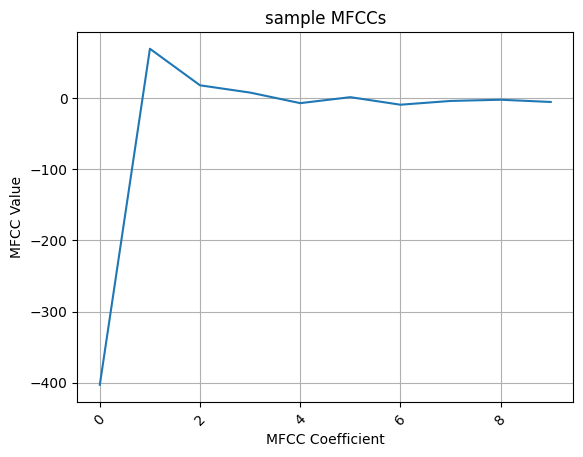

In [25]:

plt.plot(mfcc_vector)  # Assuming 'Filename' is the column with filenames

plt.xlabel('MFCC Coefficient')
plt.ylabel('MFCC Value')
plt.title(f"sample MFCCs")
# plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Callback to process

In [ ]:
"""PyAudio Example: Play a wave file (callback version)."""

import wave
import time
import sys

import pyaudio



def callback(in_data, frame_count, time_info, status):
    data = wf.readframes(frame_count)
    # If len(data) is less than requested frame_count, PyAudio automatically
    # assumes the stream is finished, and the stream stops.
    return (data, pyaudio.paContinue)

# Instantiate PyAudio and initialize PortAudio system resources (2)
p = pyaudio.PyAudio()

# Open stream using callback (3)
stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                channels=wf.getnchannels(),
                rate=wf.getframerate(),
                output=True,
                stream_callback=callback)

# Wait for stream to finish (4)
while stream.is_active():
    time.sleep(0.1)

# Close the stream (5)
stream.close()

# Release PortAudio system resources (6)
p.terminate()
